In [3]:
!git clone https://github.com/WittmannF/LRFinder.git
!git clone https://github.com/bckenstler/CLR.git

fatal: destination path 'LRFinder' already exists and is not an empty directory.
Cloning into 'CLR'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 12.70 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [5]:
# import packages
from keras.layers import BatchNormalization
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras import backend as K
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from LRFinder.keras_callback import LRFinder
from CLR.clr_callback import CyclicLR
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import AveragePooling2D
from keras.metrics import categorical_accuracy,top_k_categorical_accuracy
import torch

In [6]:
def conv_module(x,K,kX,kY, stride, chanDim, padding="same"):
        x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        return x

def inception_module(x, numK1x1, numK3x3, chanDim):
    conv_1x1 = conv_module(x, numK1x1, 1, 1,(1, 1), chanDim)
    conv_3x3 = conv_module(x, numK3x3, 3, 3,(1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis=chanDim)
    return x

def downsample_module(x, K, chanDim):
    conv_3x3 = conv_module(x, K, 3, 3, (2, 2),-1, padding="valid")
    pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([conv_3x3, pool], axis=chanDim)
    return x

def build(width, height, depth, classes):
    inputShape = (height, width, depth)
    chanDim = -1
    
    inputs = Input(shape=inputShape)
    x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)
    x = inception_module(x, 32, 32, chanDim)
    x = inception_module(x, 32, 48, chanDim)
    x = downsample_module(x, 80, chanDim)
    x = inception_module(x, 112, 48, chanDim)
    x = inception_module(x, 96, 64, chanDim)
    x = inception_module(x, 80, 80, chanDim)
    x = inception_module(x, 48, 96, chanDim)
    x = downsample_module(x, 96, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    x = AveragePooling2D((7, 7),padding = "same")(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)
    model = Model(inputs, x, name="googlenet")
    return model
    
from keras.metrics import categorical_accuracy,top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [7]:
batch_size = 64
img_width, img_height, img_num_channels = 28, 28, 1
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 5

(input_train, y_train), (input_test, y_test) = fashion_mnist.load_data()

input_shape = (img_width, img_height, img_num_channels)

input_train = input_train.astype('float32').reshape((input_train.shape[0], img_width, img_height, img_num_channels))
input_test = input_test.astype('float32').reshape((input_test.shape[0], img_width, img_height, img_num_channels))

input_train = input_train / 255
input_test = input_test / 255

4431872/4422102 [==============================] - 0s 0us/step


In [8]:
model = build(28,28,1,10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc',top_5_accuracy])
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 96)   960         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 28, 28, 96)   0           ['batch_normalization[0][

# 5.1

Epoch 1/5
938/938 [==============================] - 102s 106ms/step - loss: 2.6565 - acc: 0.0967 - top_5_accuracy: 0.3666
Epoch 2/5
938/938 [==============================] - 100s 107ms/step - loss: 2.6494 - acc: 0.0967 - top_5_accuracy: 0.3668
Epoch 3/5
938/938 [==============================] - 105s 112ms/step - loss: 2.3963 - acc: 0.1773 - top_5_accuracy: 0.3898
Epoch 4/5
938/938 [==============================] - 103s 110ms/step - loss: 1.6822 - acc: 0.4178 - top_5_accuracy: 0.5781
Epoch 5/5
938/938 [==============================] - 91s 97ms/step - loss: 8.6112 - acc: 0.1511 - top_5_accuracy: 0.5506


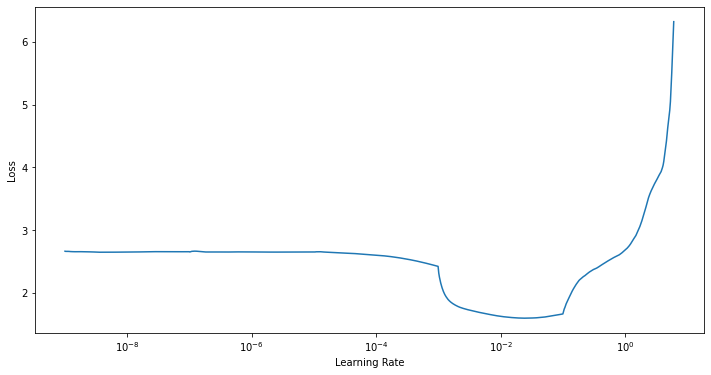

In [26]:
lr_finder = LRFinder(min_lr=1e-9, max_lr=10)
lr_history = model.fit(input_train, y_train, batch_size=64, callbacks=[lr_finder], epochs=5)

5.1

From the above plot we can see that mimimum learning rate should be around 0.001 and maximim learning rate should be around 0.01

# 5.2

In [9]:
model = build(28,28,1,10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc',top_5_accuracy])
model.summary()

clr = CyclicLR(base_lr=0.001, max_lr=0.01, step_size=3750, mode = "exp_range",gamma=0.99994)
clr_hist = model.fit(input_train, y_train, callbacks=[clr],epochs = 10,validation_split=0.2)

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 28, 28, 96)   960         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 28, 28, 96)  384         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 28, 28, 96)   0           ['batch_normalization_19[

In [14]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

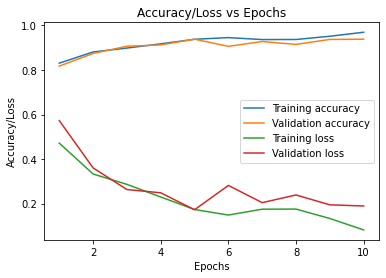

In [15]:
plt.plot(x,clr_hist.history["acc"])
plt.plot(x,clr_hist.history["val_acc"])
plt.plot(x,clr_hist.history["loss"])
plt.plot(x,clr_hist.history["val_loss"])
plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'])
plt.title("Accuracy/Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.show()

# 5.3

The following code was run on NYU HPC and the results of the same are shown in the next few cells

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

def conv_module(x,K,kX,kY, stride, chanDim, padding="same"):
        x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        return x

def inception_module(x, numK1x1, numK3x3, chanDim):
    conv_1x1 = conv_module(x, numK1x1, 1, 1,(1, 1), chanDim)
    conv_3x3 = conv_module(x, numK3x3, 3, 3,(1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis=chanDim)
    return x

def downsample_module(x, K, chanDim):
    conv_3x3 = conv_module(x, K, 3, 3, (2, 2),-1, padding="valid")
    pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([conv_3x3, pool], axis=chanDim)
    return x

def build(width, height, depth, classes):
    inputShape = (height, width, depth)
    chanDim = -1
    
    inputs = Input(shape=inputShape)
    x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)
    x = inception_module(x, 32, 32, chanDim)
    x = inception_module(x, 32, 48, chanDim)
    x = downsample_module(x, 80, chanDim)
    x = inception_module(x, 112, 48, chanDim)
    x = inception_module(x, 96, 64, chanDim)
    x = inception_module(x, 80, 80, chanDim)
    x = inception_module(x, 48, 96, chanDim)
    x = downsample_module(x, 96, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    x = AveragePooling2D((7, 7),padding = "same")(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)
    model = Model(inputs, x, name="googlenet")
    return model

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)


batch_size = 64
img_width, img_height, img_num_channels = 28, 28, 1
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 5

(input_train, y_train), (input_test, y_test) = fashion_mnist.load_data()

input_shape = (img_width, img_height, img_num_channels)

input_train = input_train.astype('float32').reshape((input_train.shape[0], img_width, img_height, img_num_channels))
input_test = input_test.astype('float32').reshape((input_test.shape[0], img_width, img_height, img_num_channels))

input_train = input_train / 255
input_test = input_test / 255


optimizer = Adam(lr=0.01)

hists = []
for i in [32,64,128,256,512,1024,2048,4096,8192,16384]:
    lr = i
    model = build(28,28,1,10)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc',top_5_accuracy])
    hist = model.fit(input_train, y_train, epochs = 5)
    hists.append(hist)
print(hists)

Text(0, 0.5, 'Training loss')

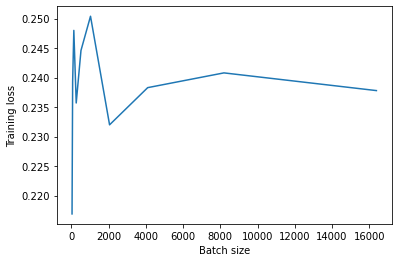

In [10]:
#the training loss values are taken from the output file provided by HPC
training_loss = [0.2169, 0.2393, 0.2480, 0.2357, 0.2446, 0.2504, 0.2320, 0.2383, 0.2408, 0.2378]
batch_size = [32,64,128,256,512,1024,2048,4096,8192,16384]

plt.plot(batch_size, training_loss)
plt.xlabel('Batch size')
plt.ylabel('Training loss')

The cyclical learning rate policy is better at genralizing than the increasing batch size policy. 

In the increasing batch size policy the training loss is more or less in between 0.2 and 0.25 where as using the cyclical learning rate policy training loss goes as low as 0.08.